# Principal Component Analysis

## Introduction

In the previous lesson we looked at our first model-based method for feature engineering: clustering. In this lesson we look at our next: principal component analysis (PCA). Just like clustering is a partitioning of the dataset based on proximity, you could think of PCA as a partitioning of the variation in the data. PCA is a great tool to help you discover important relationships in the data and can also be used to create more informative features.

(Technical note: PCA is typically applied to standardized data. With standardized data "variation" means "correlation". With unstandardized data "variation" means "covariance". All data in this course will be standardized before applying PCA.)

# Principal Component Analysis

In the Abalone dataset are physical measurements taken from several thousand Tasmanian abalone. (An abalone is a sea creature much like a clam or an oyster.) We'll just look at a couple features for now: the 'Height' and 'Diameter' of their shells.

You could imagine that within this data are "axes of variation" that describe the ways the abalone tend to differ from one another. Pictorially, these axes appear as perpendicular lines running along the natural dimensions of the data, one axis for each original feature.

*The principal components become the new features by a rotation of the dataset in the feature space.

In [ ]:
# The new features PCA constructs are actually just linear combinations (weighted sums) of the original features:

df["Size"] = 0.707 * X["Height"] + 0.707 * X["Diameter"]
df["Shape"] = 0.707 * X["Height"] - 0.707 * X["Diameter"]

## PCA for Feature Engineering

There are two ways you could use PCA for feature engineering.

The first way is to use it as a descriptive technique. Since the components tell you about the variation, you could compute the MI scores for the components and see what kind of variation is most predictive of your target. That could give you ideas for kinds of features to create -- a product of 'Height' and 'Diameter' if 'Size' is important, say, or a ratio of 'Height' and 'Diameter' if Shape is important. You could even try clustering on one or more of the high-scoring components.

The second way is to use the components themselves as features. Because the components expose the variational structure of the data directly, they can often be more informative than the original features. Here are some use-cases:

+ Dimensionality reduction: When your features are highly redundant (multicollinear, specifically), PCA will partition out the redundancy into one or more near-zero variance 
components, which you can then drop since they will contain little or no information.
+ Anomaly detection: Unusual variation, not apparent from the original features, will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task.
+ Noise reduction: A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.
+ Decorrelation: Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.

## PCA Best Practices

There are a few things to keep in mind when applying PCA:
+ PCA only works with numeric features, like continuous quantities or counts.
+ PCA is sensitive to scale. It's good practice to standardize your data before applying PCA, unless you know you have good reason not to.
+ Consider removing or constraining outliers, since they can have an undue influence on the results.

Example - 1985 Automobiles

In this example, we'll return to our Automobile dataset and apply PCA, using it as a descriptive technique to discover features. We'll look at other use-cases in the exercise.

This hidden cell loads the data and defines the functions plot_variance and make_mi_scores.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression


plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=width, dpi=dpi)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv("../../dataset/autos.csv")

We've selected four features that cover a range of properties. Each of these features also has a high MI score with the target, price. We'll standardize the data since these features aren't naturally on the same scale.

In [3]:
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
X_scaled.head()

,highway_mpg,engine_size,horsepower,curb_weight
0,-0.555613,0.045098,0.198054,-0.025646
1,-0.555613,0.045098,0.198054,-0.025646
2,-0.702307,0.574066,1.330822,0.496473
3,-0.115531,-0.459826,-0.039037,-0.426254
4,-1.289083,0.189362,0.303427,0.498371


Now we can fit scikit-learn's PCA estimator and create the principal components. You can see here the first few rows of the transformed dataset.

In [4]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


After fitting, the PCA instance contains the loadings in its components_ attribute. (Terminology for PCA is inconsistent, unfortunately. We're following the convention that calls the transformed columns in X_pca the components, which otherwise don't have a name.) We'll wrap the loadings up in a dataframe.

In [5]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings.head()

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


Recall that the signs and magnitudes of a component's loadings tell us what kind of variation it's captured. The first component (PC1) shows a contrast between large, powerful vehicles with poor gas milage, and smaller, more economical vehicles with good gas milage. We might call this the "Luxury/Economy" axis. The next figure shows that our four chosen features mostly vary along the Luxury/Economy axis.

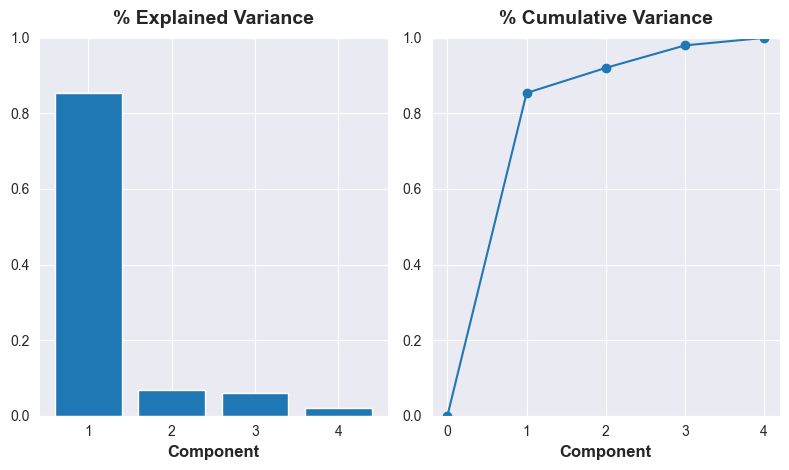

In [6]:
# Look at explained variance
plot_variance(pca);

Let's also look at the MI scores of the components.

Not surprisingly, PC1 is highly informative, though the remaining components, despite their small variance, still have a significant relationship with price. 

Examining those components could be worthwhile to find relationships not captured by the main Luxury/Economy axis.

In [7]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores.head()

PC1    1.013333
PC2    0.379649
PC3    0.307804
PC4    0.204821
Name: MI Scores, dtype: float64

The third component shows a contrast between horsepower and curb_weight -- sports cars vs. wagons, it seems.

In [8]:
# Show dataframe sorted by PC3
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body_style", "horsepower", "curb_weight"]
df.loc[idx, cols].head()

,make,body_style,horsepower,curb_weight
118,porsche,hardtop,207,2756
117,porsche,hardtop,207,2756
119,porsche,convertible,207,2800
45,jaguar,sedan,262,3950
96,nissan,hatchback,200,3139


To express this contrast, let's create a new ratio feature:

<Axes: xlabel='sports_or_wagon', ylabel='price'>

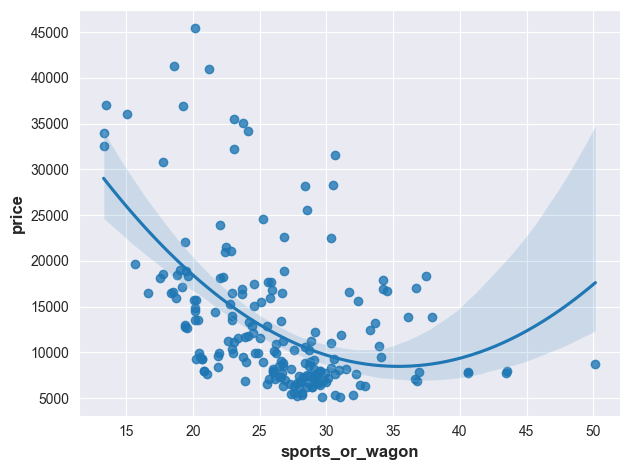

In [9]:
df["sports_or_wagon"] = X.curb_weight / X.horsepower
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2)